In [2]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:04<00:00, 2.30MB/s]


Extracting ./mnist_data/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 57.6kB/s]


Extracting ./mnist_data/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.17MB/s]


Extracting ./mnist_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.42MB/s]

Extracting ./mnist_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



In [6]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [8]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [12]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [14]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [20]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [22]:
for epoch in range(1, 51):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 164.268477
Train Epoch: 1 [10000/60000 (17%)]	Loss: 150.735254
Train Epoch: 1 [20000/60000 (33%)]	Loss: 157.614766
Train Epoch: 1 [30000/60000 (50%)]	Loss: 162.658965
Train Epoch: 1 [40000/60000 (67%)]	Loss: 152.135684
Train Epoch: 1 [50000/60000 (83%)]	Loss: 154.831309
====> Epoch: 1 Average loss: 157.1956
====> Test set loss: 154.5441
Train Epoch: 2 [0/60000 (0%)]	Loss: 154.368975
Train Epoch: 2 [10000/60000 (17%)]	Loss: 150.388291
Train Epoch: 2 [20000/60000 (33%)]	Loss: 145.106377
Train Epoch: 2 [30000/60000 (50%)]	Loss: 153.286563
Train Epoch: 2 [40000/60000 (67%)]	Loss: 147.078750
Train Epoch: 2 [50000/60000 (83%)]	Loss: 142.892021
====> Epoch: 2 Average loss: 151.8172
====> Test set loss: 150.3191
Train Epoch: 3 [0/60000 (0%)]	Loss: 144.348496
Train Epoch: 3 [10000/60000 (17%)]	Loss: 156.874355
Train Epoch: 3 [20000/60000 (33%)]	Loss: 143.026807
Train Epoch: 3 [30000/60000 (50%)]	Loss: 142.569971
Train Epoch: 3 [40000/60000 (67%)]	Loss: 146.71

In [33]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), './result' + '.png')

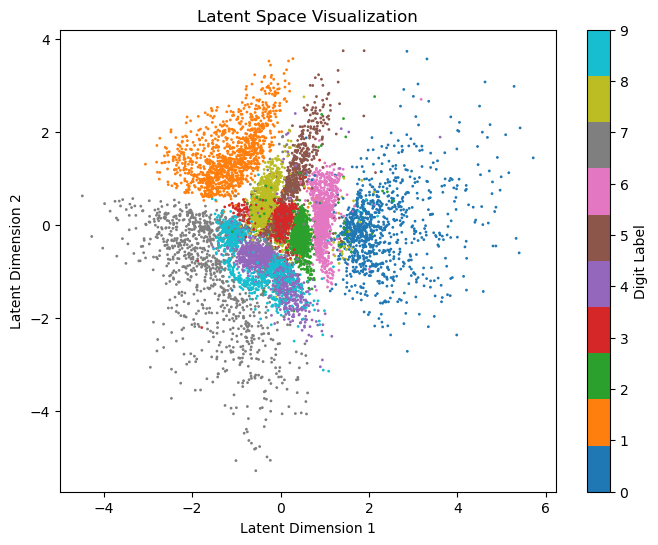

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from sklearn.decomposition import PCA

# Load the MNIST dataset (ensure you have the test dataset loaded)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# Get the latent variables (mu) for the test dataset
vae.eval()
latent_values = []
labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.cuda()
        mu, log_var = vae.encoder(data.view(-1, 784))  # Get mean (mu) of the latent space
        latent_values.append(mu.cpu().numpy())  # Store the mu values (latent variables)
        labels.append(target.cpu().numpy())  # Store corresponding labels for visualization

# Convert lists to numpy arrays
latent_values = np.concatenate(latent_values, axis=0)
labels = np.concatenate(labels, axis=0)

# Visualizing the 2D latent space using PCA (Principal Component Analysis)
# Since the latent space has 2 dimensions, you can skip this, but PCA can be useful for higher dimensions

pca = PCA(n_components=2)
latent_values_2d = pca.fit_transform(latent_values)

# Plot the latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_values_2d[:, 0], latent_values_2d[:, 1], c=labels, cmap='tab10', s=1)
plt.colorbar(scatter, label='Digit Label')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Latent Space Visualization')
plt.show()


In [39]:
import torch

# Assuming you have a batch of data (e.g., from the test set)
vae.eval()
with torch.no_grad():
    for data, target in test_loader:
        data = data.cuda()
        
        # Pass data through the encoder to get mu and log_var
        mu, log_var = vae.encoder(data.view(-1, 784))
        
        # Calculate the standard deviation (sigma) from log_var
        sigma = torch.exp(0.5 * log_var)
        
        # Print the first batch's mu and sigma values
        print(f"Mu (Mean) values for the first batch:")
        print(mu)
        
        print(f"\nSigma (Standard Deviation) values for the first batch:")
        print(sigma)
        
        # Optionally, you can print the first example's mu and sigma:
        print(f"\nMu for the first image in the batch:")
        print(mu[0])
        
        print(f"\nSigma for the first image in the batch:")
        print(sigma[0])
        
        # Break after one batch to avoid printing too much
        break


Mu (Mean) values for the first batch:
tensor([[-2.7688, -0.4381],
        [ 0.4101, -0.3594],
        [-1.4657,  1.9061],
        [ 1.7629,  0.2383],
        [ 0.2585, -1.3999],
        [-1.4427,  2.0493],
        [-0.3462, -0.5788],
        [ 0.5402, -0.9596],
        [-0.2579, -0.1227],
        [-0.9795, -1.2399],
        [ 2.1099, -0.2058],
        [ 0.9492, -0.4526],
        [-0.7857, -0.2295],
        [ 1.7468, -0.0864],
        [-1.4008,  0.8501],
        [ 0.0574, -0.0994],
        [-0.0400, -1.3916],
        [-2.0837, -3.9108],
        [ 0.1194, -0.2780],
        [-0.1691, -0.8389],
        [-1.1689, -0.4379],
        [ 0.7891,  0.2551],
        [ 0.8937, -0.5326],
        [ 0.1571,  0.9641],
        [ 0.1847, -1.0089],
        [ 3.0034,  0.4556],
        [-0.1022, -2.9089],
        [ 0.0958, -1.3410],
        [ 1.6045,  0.1068],
        [-1.8813,  0.6987],
        [-0.0257,  0.2744],
        [-2.8517,  0.8965],
        [-0.0531,  0.0487],
        [ 3.3788,  2.3140],
        [-